In [1]:
import sys
sys.path.append('./pytorch_sol2/')
#sys.path

In [2]:
from __future__ import print_function, division
import os, time, copy, sys
import pandas as pd
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import pickle
from PIL import Image

from config import *
from GalaxiesDataset import *
from rsa_loader import *
from efigi_loader import *
from pytorchtools import EarlyStopping

import pickle
from DatasetFromSubset import *
from samplers import *
from sklearn.model_selection import train_test_split

from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mySiamese import *

import warnings
warnings.filterwarnings('ignore')



import random

In [3]:
transf = transforms.Compose([transforms.Resize((105, 105)),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomRotation(degrees=(0,360)),
                             transforms.RandomVerticalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])

transformations = transforms.Compose([transforms.Resize((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_ds = GalaxiesDataset_efigi(EFIGI_DIR, EFIGI_CSV)

In [5]:
cl = []
for row in range(train_ds.classes_frame.shape[0]):
    cl.append(np.argmax(train_ds.classes_frame.loc[:,train_ds.classes_frame.columns[3:]].loc[row]))

temp = pd.DataFrame(cl,columns=['cat'])
temp['cat'] = temp['cat'].astype('category')
temp['cat'] = temp['cat'].cat.codes


In [6]:
y = torch.from_numpy(temp.values)
train_idx, valid_idx= train_test_split(
np.arange(len(y)),
test_size=0.4,
shuffle=True,
    random_state=42,
stratify=y)

valid_idx, test_idx= train_test_split(
np.arange(len(y[valid_idx])),
test_size=0.5,
shuffle=True,
    random_state=42,
stratify=y[valid_idx])

new_train = []
testers = []
y_train = y[train_idx].reshape((-1, ))
for i in range(0,12):
    l = i
    inds = np.argwhere(y_train == l)[:,0]
    testers.append(train_idx[inds[0]])
    for j in range(1, inds.shape[0]):
        new_train.append(train_idx[inds[j]])
new_train = np.array(new_train)
np.random.shuffle(new_train)
testers = np.array(testers)

In [7]:
size = len(train_ds)
indices = list(range(size))
split = int(np.floor(VALIDATION_SPLIT * size))
if SHUFFLE_DS:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

test_split = int(np.floor(VALIDATION_SPLIT * size))
if SHUFFLE_DS:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = train_indices[test_split:], train_indices[:test_split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

tng = Subset(train_ds, train_idx)
val = Subset(train_ds, valid_idx)
test = Subset(train_ds, test_idx) 
#base = Subset(train_ds, testers)

tng_dataset = DatasetFromSubset(tng, transf)
val_dataset = DatasetFromSubset(val, transformations)
test_dataset = DatasetFromSubset(test, transformations)
#base_ds = DatasetFromSubset(base, transformations)


train_dl = DataLoader(tng_dataset, batch_size=len(train_idx), num_workers=0)
val_dl = DataLoader(val_dataset, batch_size=len(valid_idx), num_workers=0)
unseen_dl = DataLoader(test_dataset, batch_size=len(test_idx), num_workers=0)
#base_dl = DataLoader(base_ds, batch_size=len(testers), num_workers=0)

#train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=0,
#                                                 sampler=train_sampler)
#val_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=0,
#                                                 sampler=val_sampler)
#unseen_dl = DataLoader(train_ds,batch_size=BATCH_SIZE, num_workers=0,
#                                                 sampler=test_sampler)
print("Total: {} Train_dl: {} Validation_dl: {} Test_dl: {}".format(size, len(train_dl),
                                                                    len(val_dl),
                                                                   len(unseen_dl)))

Total: 3122 Train_dl: 1 Validation_dl: 1 Test_dl: 1


In [8]:
len(val_dl.sampler.data_source.subset.indices)

624

In [9]:
#len(base_dl.sampler.data_source.subset.indices)

In [10]:
len(unseen_dl.sampler.data_source.subset.indices)

625

In [11]:
len(train_dl.sampler.data_source.subset.indices)

1873

In [12]:
# To just evaluate, use tr='val' 
tr = 'train'

In [13]:
if tr == 'train':
    model = torch.load('gz2_resnet50')
if tr == 'val':
    model = torch.load('./models/efigiSiamesePair')
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.00005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,threshold=0.0001,factor=0.1, verbose=True)

### class parameters ###
For random sampling: mining='random'
For triplet loss: modelType='triplet'
For contrastive loss: modelType='pair'

In [ ]:
mySiam = mySiamese(train_dl=train_dl, val_dl=val_dl, unseen_dl=unseen_dl, mining='random', model=model,
                   margin=1.2, outputSize=128,optimizer=optimizer,scheduler=scheduler,
                  modelType='triplet', device=DEVICE)
if tr == 'train':
    mySiam.train(epochs=100)

Training starting

epoch: 0
Train loss: 0.9956789036591848, Val loss: 0.8349508941173553
Validation loss decreased (inf --> 0.834951).  Saving model ...

epoch: 1
Train loss: 0.9414457003275554, Val loss: 0.782412999868393
Validation loss decreased (0.834951 --> 0.782413).  Saving model ...

epoch: 2
Train loss: 0.9061650534470876, Val loss: 0.7401562511920929
Validation loss decreased (0.782413 --> 0.740156).  Saving model ...

epoch: 3
Train loss: 0.8612610419591268, Val loss: 0.7066856563091278
Validation loss decreased (0.740156 --> 0.706686).  Saving model ...

epoch: 4
Train loss: 0.8255460957686106, Val loss: 0.6765064179897309
Validation loss decreased (0.706686 --> 0.676506).  Saving model ...

epoch: 5
Train loss: 0.7950588782628377, Val loss: 0.6501428008079528
Validation loss decreased (0.676506 --> 0.650143).  Saving model ...

epoch: 6
Train loss: 0.763510282834371, Val loss: 0.6271258115768432
Validation loss decreased (0.650143 --> 0.627126).  Saving model ...

epoch: 7

In [ ]:
mySiam.evaluate2()
#model, testPreds, trainPreds, distMatrix, train_label_anchor, predLabels, actLabels, avg_fts = mySiam.evaluate2(epochs=5000)

In [22]:
torch.argmin(mySiam.distMatrix[0])
mySiam.avg_fts.shape

torch.Size([9, 128])

In [63]:
avg_fts = torch.empty((0, mySiam.outputSize))
for lab in mySiam.unique_labs:
    inds = np.where(mySiam.trainLabels == lab)[0]
    fts = torch.empty((0, mySiam.outputSize))
    
    predss = mySiam.trainPreds[inds]
    #fts = torch.cat((fts, predss.cpu()), 0)
    avg = torch.mean(predss, 0).reshape(1,-1)
    avg_fts = torch.cat((avg_fts, avg ), 0)

In [64]:
avg_fts

tensor([[0.4779, 0.6763, 0.4429,  ..., 0.4543, 0.5724, 0.2998],
        [0.5619, 0.6690, 0.4333,  ..., 0.5127, 0.6201, 0.4085],
        [0.5534, 0.6254, 0.3225,  ..., 0.5383, 0.5035, 0.3976],
        ...,
        [0.5134, 0.6167, 0.3647,  ..., 0.5158, 0.5266, 0.4194],
        [0.4904, 0.5845, 0.3675,  ..., 0.5190, 0.5413, 0.4456],
        [0.5266, 0.5791, 0.4012,  ..., 0.5034, 0.5744, 0.4446]])

In [14]:
#model = torch.load('efigi_siamese_pair').to(DEVICE)
model = torch.load('efigi_siamese_triplet').to(DEVICE)

In [15]:
def genTriplets(batch):
    batch_size = batch['image'].shape[0]
    im_width = batch['image'].shape[2]
    in_channels = batch['image'].shape[1]
    im_height = batch['image'].shape[3]
    
    labels = np.zeros(batch_size)
    for i in range(batch_size):
        labels[i] = batch['labels'][i].argmax()
    
    batch_img_anchor = np.zeros((batch_size, in_channels*im_width*im_height))   # image set anchors
    batch_img_positive = np.zeros((batch_size, in_channels*im_width*im_height))   # image set positive
    batch_img_negative = np.zeros((batch_size, in_channels*im_width*im_height))   # image set negatives
    
    batch_label_anchor = np.zeros((batch_size, ))    # labels for anchors
    batch_label_positive = np.zeros((batch_size,))     # labels for positives
    batch_label_negative = np.zeros((batch_size,))     # labels for negatives
    
    for i in range(batch_size):
        l = labels[i]
        #Add anchor
        batch_img_anchor[i] = torch.reshape(batch['image'][i], (in_channels*im_width*im_height, ))
        batch_label_anchor[i] = l
        
        # find and add a genuine sample
        ind_positive = np.squeeze(np.argwhere(labels == l))
        randSamp = random.sample(list(ind_positive), 1)
        batch_img_positive[i] = torch.reshape(batch['image'][randSamp], (in_channels*im_width*im_height, ))
        batch_label_positive[i] = l
        
        
        # find and add a negative sample
        ind_negative = np.squeeze(np.argwhere(labels != l))
        randSamp = random.sample(list(ind_negative), 1)
        batch_img_negative[i] = torch.reshape(batch['image'][randSamp], (in_channels*im_width*im_height, ))
        batch_label_negative[i] = labels[randSamp]
        
    batch_img_anchor = batch_img_anchor.reshape((-1, in_channels, im_width, im_height))
    batch_img_positive = batch_img_positive.reshape((-1, in_channels, im_width, im_height))
    batch_img_negative = batch_img_negative.reshape((-1, in_channels, im_width, im_height))
    
    batch_label_anchor = torch.from_numpy(batch_label_anchor).long()  # convert the numpy array into torch tensor
    batch_label_positive = torch.from_numpy(batch_label_positive).long()  # convert the numpy array into torch tensor
    batch_label_negative = torch.from_numpy(batch_label_negative).long()  # convert the numpy array into torch tensor
    
    batch_img_anchor = torch.from_numpy(batch_img_anchor).float()     # convert the numpy array into torch tensor
    batch_img_positive = torch.from_numpy(batch_img_positive).float()  # convert the numpy array into torch tensor
    batch_img_negative = torch.from_numpy(batch_img_negative).float()  # convert the numpy array into torch tensor
    
    return batch_img_anchor, batch_img_positive, batch_img_negative, batch_label_anchor, batch_label_positive, batch_label_negative

In [16]:
def genPair(batch):
    batch_size = batch['image'].shape[0]
    im_width = batch['image'].shape[2]
    in_channels = batch['image'].shape[1]
    im_height = batch['image'].shape[3]
    
    labels = np.zeros(batch_size)
    for i in range(batch_size):
        labels[i] = batch['labels'][i].argmax()
    
    batch_img_1 = np.zeros((2 * batch_size, in_channels*im_width*im_height))   # image set 1
    batch_img_2 = np.zeros((2 * batch_size, in_channels*im_width*im_height))   # image set 2
    batch_label_1 = np.zeros((2 * batch_size, ))    # labels for image set 1
    batch_label_2 = np.zeros((2 * batch_size,))     # labels for image set 2
    batch_label_c = np.zeros((2 * batch_size,))     # contrastive label: 0 if genuine pair, 1 if impostor pair
    
    for i in range(batch_size):
        l = labels[i]
        # find and add a genuine sample
        ind_g = np.squeeze(np.argwhere(labels == l))
        batch_img_1[2*i] = torch.reshape(batch['image'][i], (in_channels*im_width*im_height, ))
        #print('label - {} #similars - {}'.format(labels[i], len(ind_g)))
        randSamp = random.sample(list(ind_g), 1)
        batch_img_2[2*i] = torch.reshape(batch['image'][randSamp], (in_channels*im_width*im_height, ))
        batch_label_1[2*i] = l
        batch_label_2[2*i] = l
        batch_label_c[2*i] = 0
        
        # find and add an impostor sample
        ind_d = np.squeeze(np.argwhere(labels != l))
        randSamp = random.sample(list(ind_d), 1)
        batch_img_1[2*i+1] = torch.reshape(batch['image'][i], (in_channels*im_width*im_height, ))
        batch_img_2[2*i+1] = torch.reshape(batch['image'][randSamp], (in_channels*im_width*im_height, ))
        batch_label_1[2*i+1] = l
        batch_label_2[2*i+1] = labels[randSamp]
        batch_label_c[2*i+1] = 1
        
    batch_img_1 = batch_img_1.reshape((-1, in_channels, im_width, im_height))
    batch_img_2 = batch_img_2.reshape((-1, in_channels, im_width, im_height))
    
    batch_label_1 = torch.from_numpy(batch_label_1).long()  # convert the numpy array into torch tensor
    #batch_label_1 = Variable(batch_label_1).cuda()          # create a torch variable and transfer it into GPU

    batch_label_2 = torch.from_numpy(batch_label_2).long()  # convert the numpy array into torch tensor
    #batch_label_2 = Variable(batch_label_2).cuda()          # create a torch variable and transfer it into GPU

    batch_label_c = batch_label_c.reshape((-1, 1))
    batch_label_c = torch.from_numpy(batch_label_c).float()  # convert the numpy array into torch tensor
    #batch_label_c = Variable(batch_label_c).cuda()           # create a torch variable and transfer it into GPU

    batch_img_1 = torch.from_numpy(batch_img_1).float()     # convert the numpy array into torch tensor
    #batch_img_1 = Variable(batch_img_1).cuda()              # create a torch variable and transfer it into GPU

    batch_img_2 = torch.from_numpy(batch_img_2).float()  # convert the numpy array into torch tensor
    #batch_img_2 = Variable(batch_img_2).cuda()           # create a torch variable and transfer it into GPU
    return batch_img_1, batch_img_2, batch_label_1, batch_label_2, batch_label_c
#batch_img_1, batch_img_2, batch_label_1, batch_label_2, batch_label_c

In [17]:
for i, batch in enumerate(train_dl):  # batches loop
    #train_img_1, train_img_2, train_label_1, train_label_2, train_label_c = genPair(batch)
    train_img_anchor, train_img_positve, train_img_negative, train_label_anchor, train_label_positive, train_label_negative = genTriplets(batch)
train_sample_size = train_img_anchor.shape[0]

In [18]:
test_ds = GalaxiesDataset_rsa(TEST_DIR, TEST_CSV, transform=transformations)
size = len(test_ds)
indices = list(range(size))
test_sampler = SubsetRandomSampler(indices)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=0,
                                                 sampler=test_sampler)
print("Total: {} Test_dl: {}".format(size, len(test_dl)))

Total: 1249 Test_dl: 32


In [19]:
len(test_dl.dataset)

1249

In [20]:
n = len(test_dl.dataset)
m = train_sample_size
distMatrix = torch.empty((n, m))
predLabels = torch.empty((n, 1))
actLabels = torch.empty((0, 1))
testPreds = torch.empty((0, 128))
trainPreds = torch.empty((0, 128))
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
d = nn.PairwiseDistance(p=2)
#euclidean_distance = cos(features_1, features_2)
model.eval()
for i, batch in enumerate(test_dl):
    with torch.no_grad():
        testPreds = F.normalize(torch.cat((testPreds, model(batch['image'].cuda()).cpu()), 0), 2)
        #actLabels = torch.argmax(batch['labels'], 1).float().reshape(-1,1))
        actLabels = torch.cat((actLabels, torch.argmax(batch['labels'], 1).float().reshape(-1,1)), 0)
for j in range(0, m, 64):
    with torch.no_grad():
        preds = F.normalize(model(train_img_anchor[j: j + 64].cuda()), 2)
        trainPreds = torch.cat((trainPreds, preds.cpu()), 0)
for row in range(0, n):
    for col in range(0, m):
        distMatrix[row, col] = d(testPreds[row].reshape(1,-1).cuda(),
                                                               trainPreds[col].reshape(1,-1).cuda()).cpu()
        torch.cuda.empty_cache()
for r in range(0, n):
    ind = torch.argmin(distMatrix[r])
    predLabels[r, 0] = train_label_anchor[ind]

In [21]:
classifier = nn.Sequential(nn.Linear(in_features=128, out_features=64, bias = True),
             nn.ReLU(),
              nn.Dropout(p=0.25, inplace=False),
              #nn.Linear(in_features=64, out_features=32, bias=True),
              #nn.ReLU(),
              #nn.Dropout(p=0.25),
              nn.Linear(in_features=64, out_features=9, bias=True)                           
             )
classifier = classifier.to(DEVICE)

In [22]:
#one_hot = torch.nn.functional.one_hot(train_label_1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01, weight_decay=0.00005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3,threshold=0.0001,factor=0.1, verbose=True)

In [23]:
train_idx, valid_idx= train_test_split(
np.arange(train_label_anchor.shape[0]),
test_size=0.4,
shuffle=True,
    random_state=42,
stratify=train_label_anchor)

In [24]:
def train_classifier(tr='train'):
    if tr == 'train':
        classifier.train()
        losses = []
        m = train_idx.shape[0]
        for i in range(0, m, 64):
            #torch.cuda.empty_cache()
            inputs = trainPreds[train_idx[i: i + 64]].cuda()
            labels = train_label_anchor[train_idx[i: i + 64]]
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()             # 1. Zero the parameter gradients
            outputs = classifier(inputs)           # 2. Run the model

            loss = criterion(outputs, labels) # 3. Calculate loss
            #loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss = torch.sqrt(loss)           #    -> RMSE loss
            loss.backward()                   # 4. Backward propagate the loss
            optimizer.step()                  # 5. Optimize the network

            del inputs
            del labels
            torch.cuda.empty_cache()
        epoch_loss = sum(losses) / len(losses)
    elif tr =='val':
        classifier.eval()
        losses = []
        m = valid_idx.shape[0]
        for i in range(0, m, 64):
            #torch.cuda.empty_cache()
            inputs = trainPreds[valid_idx[i: i + 64]].cuda()
            labels = train_label_anchor[valid_idx[i: i + 64]]
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()             # 1. Zero the parameter gradients
            outputs = classifier(inputs)           # 2. Run the model

            loss = criterion(outputs, labels) # 3. Calculate loss
            #loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss = torch.sqrt(loss)           #    -> RMSE loss
            loss.backward()                   # 4. Backward propagate the loss
            optimizer.step()                  # 5. Optimize the network

            del inputs
            del labels
            torch.cuda.empty_cache()
        epoch_loss = sum(losses) / len(losses)
    
    return epoch_loss

Epoch: 1 Train Loss: 1.7742212679651048
Epoch: 1 Val Loss: 1.3845727642377217
Epoch: 2 Train Loss: 1.3570276829931471
Epoch: 2 Val Loss: 1.3568746050198872
Epoch: 3 Train Loss: 1.3277714848518372
Epoch: 3 Val Loss: 1.3266844948132832
Epoch: 4 Train Loss: 1.3109112646844652
Epoch: 4 Val Loss: 1.3101145227750142
Epoch: 5 Train Loss: 1.2909822530216641
Epoch: 5 Val Loss: 1.3157814343770344
Epoch: 6 Train Loss: 1.2932830055554707
Epoch: 6 Val Loss: 1.2947402894496918
Epoch: 7 Train Loss: 1.2806612915462918
Epoch: 7 Val Loss: 1.296590507030487
Epoch: 8 Train Loss: 1.2828580273522272
Epoch: 8 Val Loss: 1.287672261397044
Epoch: 9 Train Loss: 1.2737583716710408
Epoch: 9 Val Loss: 1.2866945664087932
Epoch: 10 Train Loss: 1.274703840414683
Epoch: 10 Val Loss: 1.2861669858296711
Epoch: 11 Train Loss: 1.2711840205722384
Epoch: 11 Val Loss: 1.2793244918187459
Epoch: 12 Train Loss: 1.253354377216763
Epoch: 12 Val Loss: 1.2812305291493733
Epoch: 13 Train Loss: 1.250222875012292
Epoch: 13 Val Loss: 1.

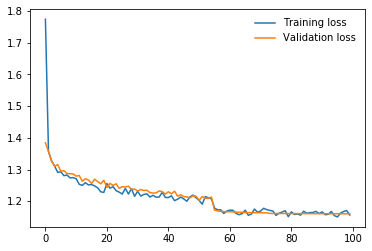

In [25]:
train_losses = []
val_losses= []
#initialize the early_stopping object
pth = './classifier'
early_stopping = EarlyStopping(patience=10, verbose=True, path=pth)
for epoch in range(100):
    train_loss = train_classifier()
    train_losses.append(train_loss)
    print("Epoch: {} Train Loss: {}".format(epoch+1, train_loss))
    
    val_loss = train_classifier(tr='val')
    val_losses.append(val_loss)
    print("Epoch: {} Val Loss: {}".format(epoch+1, val_loss))
    scheduler.step(val_loss)

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [26]:
X = trainPreds.numpy()
y = train_label_anchor.numpy()

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(C=10)
rf = RandomForestClassifier(criterion='entropy')
params = {'n_estimators': [1500, 2500],
         'max_depth': [25, 30, 35]}
gs = GridSearchCV(rf, params)
gs.fit(X_train, y_train)
rfc = gs.best_estimator_
#svm.fit(X_train, y_train)

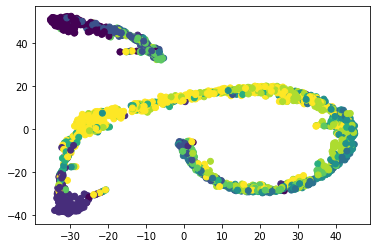

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
X_transf = TSNE(n_components=2, perplexity=50, learning_rate=1000).fit_transform(X)
plt.scatter(X_transf[:,0], X_transf[:,1], c=y)

In [28]:
#dff = pd.DataFrame(X_transf, columns=['x','y'])
#dff['label'] = y
#dff[(dff['x'] >= 20) & (dff['x'] <= 40)][(dff['y'] <= 50) & (dff['y'] >= 40)]

In [29]:
svmPreds = rfc.predict(X_test)
#rfc.score(X_test, y_test.reshape(-1,1))
pp = rfc.predict(testPreds.cpu().numpy())
rfc.score(X_test, y_test.reshape(-1,1))

0.6026666666666667

In [37]:
n = len(unseen_dl.dataset)
m = train_sample_size
unseenPredLabels = torch.empty((n, 1))
unseenActLabels = torch.empty((0, 1))
unseenPreds = torch.empty((0, 128))
model.eval()
for i, batch in enumerate(unseen_dl):
    with torch.no_grad():
        unseenPreds = torch.cat((unseenPreds, model(batch['image'].cuda()).cpu()), 0)
        #actLabels = torch.argmax(batch['labels'], 1).float().reshape(-1,1))
        unseenActLabels = torch.cat((unseenActLabels, torch.argmax(batch['labels'], 1).float().reshape(-1,1)), 0)

In [39]:
unseenTest = unseenPreds.numpy()
rfc.score(unseenTest, unseenActLabels.numpy().reshape(-1, 1))

0.6032

In [48]:
f1_score(rfc.predict(unseenTest), unseenActLabels.numpy(), average='weighted')


0.5906711217004452

In [40]:
#torch.argmax(classifier(testPreds[65: 128].cuda()), 1)
class_test = torch.empty((0, 9))
for i in range(0, testPreds.shape[0], 64):
    class_test = torch.cat((class_test, classifier(testPreds[i: i + 64].cuda()).cpu()), 0)

In [41]:
predLabs = torch.argmax(class_test, 1).numpy()

In [42]:
efigi = pd.read_csv('efigi_model.csv')
efigi['codes'] = efigi['hubb'].astype('category').cat.codes
efigi = efigi.loc[:, ['hubb','codes']]
efigi = efigi.drop_duplicates(subset=['hubb'])

In [43]:
df = pd.DataFrame(predLabs, columns=['Predict'])
#predLabels.numpy()
df['Act'] = actLabels.numpy()
df.head()

,Predict,Act
0,7,7.0
1,0,7.0
2,6,9.0
3,7,10.0
4,5,7.0


In [44]:
orig_df = test_dl.dataset.classes_frame
orig_df['cat'] = 0
for i in range(orig_df.shape[0]):
    orig_df.loc[i,'cat'] = np.argmax(orig_df.iloc[i,2:].values)
orig_df = orig_df.loc[:, ['New type', 'cat']].drop_duplicates()
orig_df

,New type,cat
0,Sc,10
1,Sa,8
3,E3-5,1
4,Sb,9
5,SBb,6
6,SBc,7
9,E0,0
10,S0,4
23,Irr,3
38,SBa,5


In [45]:
sdf = pd.merge(df, orig_df, left_on=['Act'], right_on=['cat'], how='left')
sdf = pd.merge(sdf, efigi, left_on=['Predict'], right_on=['codes'], how='left')
sdf.head()

,Predict,Act,New type,cat,hubb,codes
0,7,7.0,SBc,7,Sb,7
1,0,7.0,SBc,7,E,0
2,6,9.0,Sb,9,Sa,6
3,7,10.0,Sc,10,Sb,7
4,5,7.0,SBc,7,SBc,5


In [46]:
change = sdf[sdf['New type'].isin(['E0','E3-5','E7'])].index.tolist()
sdf.loc[change, 'New type'] = 'E'

In [47]:
f1_score(sdf['New type'], sdf['hubb'], average='macro')

0.23947913107226895

In [48]:
sdf[sdf['New type'] == sdf['hubb']].shape[0]/sdf.shape[0]

0.26501200960768617

In [49]:
cf = ConfusionMatrix(sdf['New type'].tolist(), sdf['hubb'].tolist())
#cf = confusion_matrix(sdf['New type'].tolist(), sdf['hubb'].tolist(), labels=['E','Irr','S0','SBa','SBb','SBc','Sa','Sb','Sc'])
#C = cf / cf.astype(np.float).sum(axis=1, keepdims=True)
print("Confusion matrix:\n%s" % cf)

Confusion matrix:
Predicted    E  Irr   S0  SBa  SBb  SBc   Sa  Sb  Sc  __all__
Actual                                                       
E          106    0   44    0    0    0   23   0   1      174
Irr         10    8    1    0    0    6   11   1   4       41
S0          47    9   40    1    0    0   67   9   1      174
SBa         14    2   14   17    1    0   12   4   1       65
SBb         30    7    5    9   14    2   17   9   3       96
SBc         19   19    5    5    7   14   18   5   9      101
Sa          32    3   26    5    4    2   65   8   2      147
Sb          36    4   23    2    9    3   68  22  12      179
Sc          47   20   17    9   13   12   68  41  45      272
__all__    341   72  175   48   48   39  349  99  78     1249


In [14]:
unique_labs = torch.unique(train_label_anchor)
avg_fts = torch.empty((0, 37))
for lab in unique_labs:
    inds = np.where(train_label_anchor == lab)[0]
    fts = torch.empty((0, 37))
    #fts = trainPreds[inds]
    for k in range(0, inds.shape[0], BATCH_SIZE):
        with torch.no_grad():
            #preds = model(train_img_anchor[inds[j: j + BATCH_SIZE]].cuda())
            preds = trainPreds[inds[k: k + BATCH_SIZE]]
            fts = torch.cat((fts, preds.cpu()), 0)
    avg = torch.mean(fts, 0).reshape(1,-1)
    avg_fts = torch.cat((avg_fts, avg ), 0)
print(avg_fts)

NameError: name 'train_label_anchor' is not defined

In [ ]:
n = testPreds.shape[0]
n_classes = 9
d = nn.PairwiseDistance(p=2)
for row in range(0, n):
                for col in range(0, n_classes):
                    distMatrix[row, col] = d(testPreds[row].reshape(1,-1).cuda(),
                                                               avg_fts[col].reshape(1,-1).cuda()).cpu()

In [21]:
un = []
count = 0
for i in range(distMatrix.shape[0]):
    un.append(torch.argmin(distMatrix[i]))


In [22]:
from sklearn.metrics import f1_score
f1_score(actLabels, un, average='macro')

0.5356896720743705

In [23]:
count = 0
for i in range(len(un)):
    if un[i] == actLabels[i].long():
        count += 1
count/len(un)

0.5296